In [1]:
import torch
from torch import nn

In [20]:
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "/kaggle/input/carvana-image-masking-png/train_images/"
TRAIN_DIR_MASK = "/kaggle/input/carvana-image-masking-png/train_masks/"
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_WORKERS = 2
NUM_EPOCHS = 200
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_UNET = "unetres.pth.tar"

both_transform = A.Compose(
    [A.Resize(width=256, height=256), A.HorizontalFlip(p=0.5)], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        ToTensorV2(),
    ]
)

In [3]:
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

class CarDataset(Dataset):
    def __init__(self, root_dir, mask_dir):
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.list_file = os.listdir(self.root_dir)

        
    def __len__(self):
        return len(self.list_file)
    

    def __getitem__(self, index):
        img_file = self.list_file[index]
        img_path = os.path.join(self.root_dir, img_file)
        mask_path = os.path.join(self.mask_dir, img_file)
        input_img = np.array(Image.open(img_path))
        target_img = np.array(Image.open(mask_path[:-3] + "png"))
        
        augmentations = both_transform(image=input_img, image0=target_img)
        input_img, target_img = augmentations['image'], augmentations['image0']
        
        input_img = transform_only_input(image=input_img)['image']
        target_img = transform_only_mask(image=target_img)['image']
        
        return input_img, target_img

(tensor([  0., 255.]), tensor([44106, 21430]))


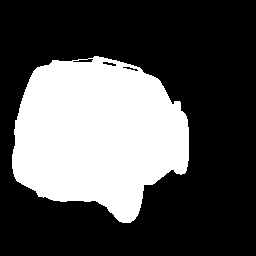

In [4]:
from torch.utils.data import DataLoader
te_dataset = CarDataset(root_dir=TRAIN_DIR, mask_dir=TRAIN_DIR_MASK)
te_loader = DataLoader(te_dataset, batch_size=1, shuffle=True, num_workers=1)

batch= iter(te_loader)
images, labels = next(batch)
import torchvision.transforms as T
labels[0].shape
print(torch.unique(labels[0].float() * 255, return_counts=True))
transform = T.ToPILImage()
transform(labels[0].float())

In [14]:
import torch
from torchvision.utils import save_image

def save_some_examples(unet, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    unet.eval()
    with torch.no_grad():
        y_fake = unet(x)
        y_fake[y_fake > 0.5] = 1  # remove normalization#
        y_fake[y_fake <= 0.5] = 0  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        save_image(y.float() , folder + f"/label_{epoch}.png")
    unet.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load("/kaggle/working/" + checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


In [6]:
class BNReLU(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.x = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.x(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.conv = nn.Sequential(
            BNReLU(in_channels),
            nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride),
            BNReLU(out_channels),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=1),
        )
        
        self.s = nn.Conv2d(in_channels, out_channels, 1, padding=0, stride=stride)
    
    def forward(self, inputs):
        x = self.conv(inputs)
        s = self.s(inputs)

        return x + s
        
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.res = ResidualBlock(in_channels + out_channels, out_channels)
        
    def forward(self, inputs, skip):
        x = self.upsample(inputs)
        
        x = torch.cat([x, skip], dim=1)
        return self.res(x)
        
class Resunet(nn.Module):
    def __init__(self, in_channels, out_channels, features=64):
        super().__init__()
        
        # Encoder 1
        self.conv = nn.Conv2d(in_channels, features, 3, 1, 1)
        self.bnr = BNReLU(features)
        self.conv2 = nn.Conv2d(features, features, 3, 1, 1)
        self.conv3 = nn.Conv2d(in_channels, features, 1, 1, 0)
        
        # Encoder 2, 3
        self.r2 = ResidualBlock(features, features * 2, stride=2)
        self.r3 = ResidualBlock(features* 2, features * 4, stride=2)
        
        # Bridge
        self.r4 = ResidualBlock(features* 4, features * 8, stride=2)
        
        # Decoder
        self.d1 = DecoderBlock(features * 8, features * 4)
        self.d2 = DecoderBlock(features * 4, features * 2)
        self.d3 = DecoderBlock(features * 2, features)
        
        self.final = nn.Conv2d(features, out_channels, kernel_size=1, padding=0)
        
    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.bnr(x)
        x = self.conv2(x)
        s = self.conv3(inputs)

        skip1 = x + s
        
        # Encoder 2, 3
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)
        
        # Bridge
        b = self.r4(skip3)
        
        # Decoder
        d1 = self.d1(b, skip3)
        d2 = self.d2(d1, skip2)
        d3 = self.d3(d2, skip1)
        
        return self.final(d3)
    
x = torch.randn((5, 3, 64, 64))
model = Resunet(3, 3)
print(model(x).shape)

torch.Size([5, 3, 64, 64])


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image
print(SAVE_MODEL)
torch.backends.cudnn.benchmark = True

def train_fn(unet, train_loader, opt, loss_fn, scaler):
    loop = tqdm(train_loader, leave=True)
    
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.float().to(DEVICE)
        
        #Train Discriminator
        with torch.cuda.amp.autocast():
            segment = unet(x)
            loss = loss_fn(segment, y)
        opt.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        loop.set_postfix(loss=loss.item())

        
        
def main():
    unet = Resunet(in_channels=3, out_channels=1).to(DEVICE)
    opt=optim.Adam(unet.parameters(), lr=LEARNING_RATE)
    
    loss = nn.BCEWithLogitsLoss()
    
    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_UNET, unet, opt, LEARNING_RATE)
        
    train_dataset = CarDataset(root_dir=TRAIN_DIR, mask_dir=TRAIN_DIR_MASK)
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(1))
    scaler = torch.cuda.amp.GradScaler()
    
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    
    for epoch in range(NUM_EPOCHS):
        train_fn(unet, train_loader, opt, loss, scaler)
        
        if(SAVE_MODEL and epoch % 5 == 0):
            save_checkpoint(unet, opt, filename=CHECKPOINT_UNET)
        if epoch % 5 == 0:
            save_some_examples(unet, val_loader, epoch, folder='.')

main()

True


100%|██████████| 255/255 [03:27<00:00,  1.23it/s, loss=0.14]  


=> Saving checkpoint


100%|██████████| 255/255 [02:43<00:00,  1.56it/s, loss=0.0744]


=> Saving checkpoint


100%|██████████| 255/255 [02:43<00:00,  1.56it/s, loss=0.118] 


=> Saving checkpoint


100%|██████████| 255/255 [02:43<00:00,  1.56it/s, loss=0.0553]


=> Saving checkpoint


100%|██████████| 255/255 [02:43<00:00,  1.55it/s, loss=0.0464]


=> Saving checkpoint


100%|██████████| 255/255 [02:43<00:00,  1.56it/s, loss=0.0321]


=> Saving checkpoint


100%|██████████| 255/255 [02:43<00:00,  1.56it/s, loss=0.0376]


=> Saving checkpoint


 89%|████████▉ | 228/255 [02:26<00:17,  1.56it/s, loss=0.0283]


KeyboardInterrupt: 

In [17]:
train_dataset = CarDataset(root_dir=TRAIN_DIR, mask_dir=TRAIN_DIR_MASK)
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(1))
    
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
unet = Resunet(in_channels=3, out_channels=1).to(DEVICE)
opt=optim.Adam(unet.parameters(), lr=LEARNING_RATE)
load_checkpoint(CHECKPOINT_UNET, unet, opt, LEARNING_RATE)
save_some_examples(unet, val_loader, 101, folder='.')


=> Loading checkpoint


In [ ]:
unet

In [22]:
sum(p.numel() for p in unet.parameters() if p.requires_grad)

8220993